(neural-network-universal-approximator)=
# Neural Network as an Universal Approximator

In [30]:
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
architecture_name = "regularized_autoencoder"
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [100]:
x1    = 2*np.pi*np.linspace(0,1.5,10000) 
x2    = x1*np.cos(2*x1)
x3    = np.exp(-x1)*x1

X_data = np.concatenate((x1.reshape(x1.shape[0],1),\
                       x2.reshape(x1.shape[0],1)),axis=1)
X_data = StandardScaler().fit_transform(X_data)
                        
X = torch.Tensor(X_data[:,0]).type(torch.FloatTensor)
y = torch.Tensor(X_data[:,1]).type(torch.FloatTensor)


# X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
# print(X_tc.shape, X_tc.type())
# torch.Size([1000, 3]) torch.FloatTensor

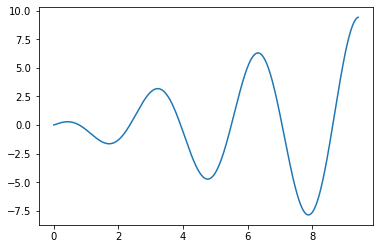

In [101]:
plt.plot(x1,x2)

In [102]:
def create_loader(X,y,batch_size=50,workers=12):
    torch_dataset = Data.TensorDataset(X,y)
    loader = Data.DataLoader(
            dataset = torch_dataset,
            batch_size = batch_size,
            shuffle=True)
    return loader

### Usando weight_decay do Adam

In [103]:
class Net(nn.Module):
    def __init__(self,h_dim=1,ngpu=ngpu):
        super(Net, self).__init__()
        self.h_dim = h_dim
        self.hidden = nn.Linear(1, self.h_dim)
        self.act1 = nn.ReLU()
        self.out = nn.Linear(self.h_dim, 1)
        
    def forward(self, x):
        h = self.act1(self.hidden(x))
        return self.out(h)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)
    
def define_model(model_class,h_dim):
    # Instanciamos as redes
    net = model_class(h_dim).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))

    # Inicializamos os pesos
    net.apply(init_weights)

    learning_rate, beta1, beta2 = [1e-3,0.9,0.999]
    eps,weight_decay,amsgrad = [1e-12,0.0,False]
    net_optimizer = optim.Adam(net.parameters(),
                               lr=learning_rate,
                               betas=(beta1,beta2),
                               eps=eps,
                               weight_decay=weight_decay, # regularization: https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
                               amsgrad=amsgrad)
    return net,net_optimizer

mse_loss = nn.MSELoss()

In [104]:
def test_approximator(net,X,y,h_dim):
    y_pred = net(X.view(-1,1).to(device)).detach()
    plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
    plt.plot(X.cpu().numpy(),y_pred.cpu().numpy(),label="approx")
    plt.xlabel(f"{h_dim}")
    plt.legend(loc=0)
    plt.show()

In [105]:
loader = create_loader(X,y,batch_size=5,workers=12)

In [125]:
# net,net_optimizer = define_model(Net,5)
models = [define_model(Net,h_dim) for h_dim in [1,5,20,30,50,100]]

In [113]:
def train_model(model,optimizer):
    for epoch in range(20):
        loss_ = []
        for _, (X_train,y_train) in enumerate(loader):
            X_train = X_train.view(-1,1).to(device)
            y_train = y_train.view(-1,1).to(device)
            y_pred = model(X_train)
            loss = mse_loss(y_pred,y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

#         print("Training loss for {} epoch: {}".format(epoch, loss))
    return model

In [126]:
model_1    = train_model(models[0][0],models[0][1])
model_5    = train_model(models[1][0],models[1][1])
model_20   = train_model(models[2][0],models[2][1])
model_30   = train_model(models[3][0],models[3][1])
model_50   = train_model(models[4][0],models[4][1])
model_100  = train_model(models[5][0],models[5][1])

In [141]:
y_pred = []
y_pred.append(model_1(X.view(-1,1).to(device)).detach())
y_pred.append(model_5(X.view(-1,1).to(device)).detach())
y_pred.append(model_20(X.view(-1,1).to(device)).detach())
y_pred.append(model_30(X.view(-1,1).to(device)).detach())
y_pred.append(model_50(X.view(-1,1).to(device)).detach())
y_pred.append(model_100(X.view(-1,1).to(device)).detach())

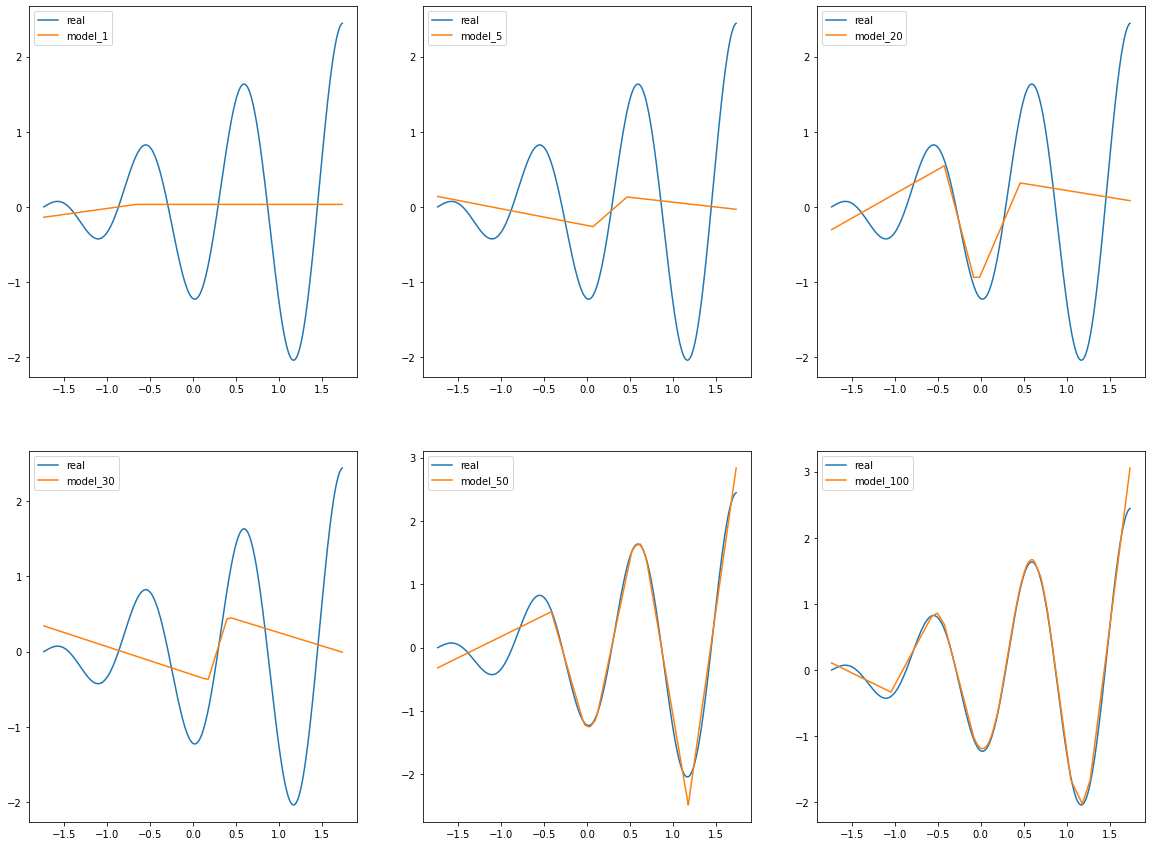

In [144]:
plt.figure(figsize=(20,15))
plt.subplot(231)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[0].detach().cpu().numpy(),label="model_1")
plt.legend(loc=0)
plt.subplot(232)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[1].detach().cpu().numpy(),label="model_5")
plt.legend(loc=0)
plt.subplot(233)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[2].detach().cpu().numpy(),label="model_20")
plt.legend(loc=0)
plt.subplot(234)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[3].detach().cpu().numpy(),label="model_30")
plt.legend(loc=0)
plt.subplot(235)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[4].detach().cpu().numpy(),label="model_50")
plt.legend(loc=0)
plt.subplot(236)
plt.plot(X.cpu().numpy(),y.cpu().numpy(),label="real")
plt.plot(X.cpu().numpy(),y_pred[5].detach().cpu().numpy(),label="model_100")
plt.legend(loc=0)
plt.show()